In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
y  = np.load('kepsilonphitf/kepsilonphitf_DUCT_1100_Cy.npy')
z  = np.load('kepsilonphitf/kepsilonphitf_DUCT_1100_Cz.npy')
wd = np.load('kepsilonphitf/kepsilonphitf_DUCT_1100_wallDistance.npy')
uu = np.load('labels/DUCT_1100_uu.npy')
vv = np.load('labels/DUCT_1100_vv.npy')
ww = np.load('labels/DUCT_1100_ww.npy')
b  = np.load('labels/DUCT_1100_b.npy')

In [3]:
b.shape

(9216, 3, 3)

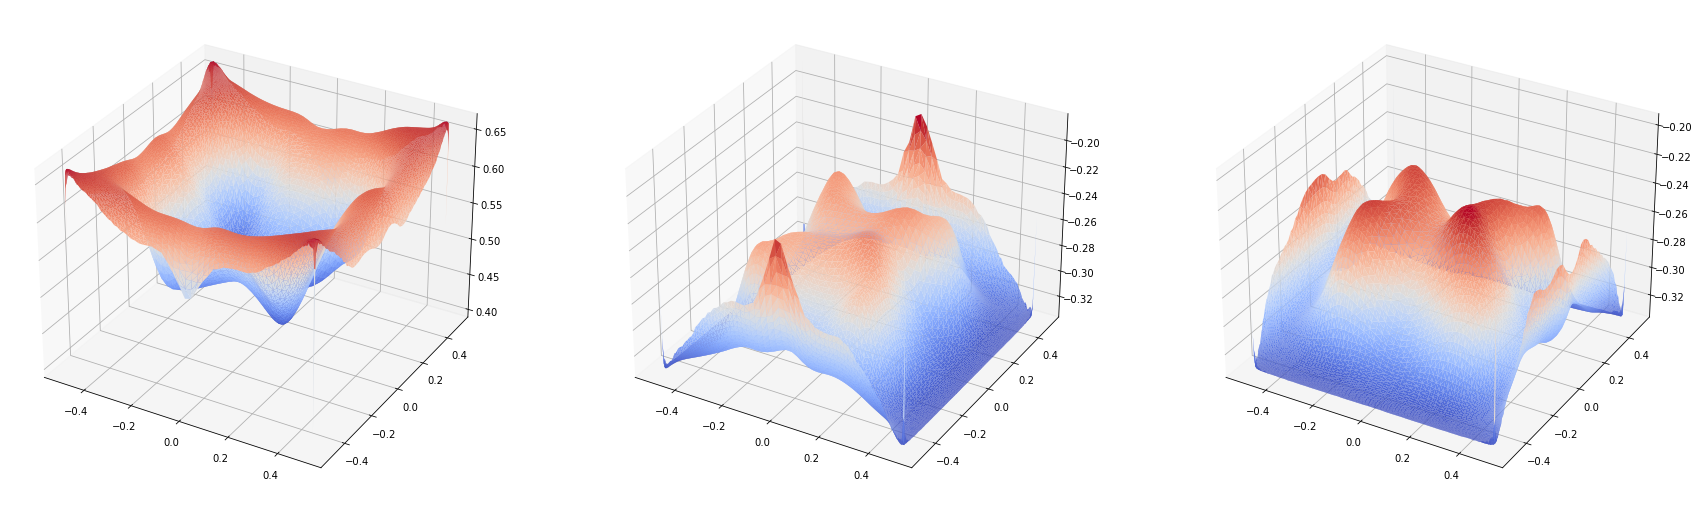

In [4]:
import matplotlib.tri as mtri
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,3,1,projection='3d')
ax.plot_trisurf(z, y, np.array([i[0][0] for i in b]), cmap='coolwarm')
ax = fig.add_subplot(1,3,2,projection='3d')
ax.plot_trisurf(z, y, np.array([i[1][1] for i in b]), cmap='coolwarm')
ax = fig.add_subplot(1,3,3,projection='3d')
ax.plot_trisurf(z, y, np.array([i[2][2] for i in b]), cmap='coolwarm')

In [5]:
cases = ['DUCT_1100',
         'DUCT_1150',
         'DUCT_1250',
         'DUCT_1300',
         'DUCT_1350',
         'DUCT_1400',
         'DUCT_1500',
         'DUCT_1600',
         'DUCT_1800',
         'DUCT_2205',
         'DUCT_2400',
         'DUCT_2600',
         'DUCT_2900',
         'DUCT_3200',
         'PHLL_case_0p5',
         'PHLL_case_0p8',
         'PHLL_case_1p0',
         'PHLL_case_1p5',
         'BUMP_h20',
         'BUMP_h26',
         'BUMP_h31',
         'BUMP_h42',
         'CNDV_12600',
         'CNDV_20580',
         'CBFS_13700'
         ]

In [6]:
dataset_path = './kepsilon/kepsilon_'

tensors = np.concatenate([np.load(dataset_path + case + '_Tensors.npy') for case in cases])
invars = np.concatenate([np.load(dataset_path + case + '_I.npy') for case in cases])
scalars = np.concatenate([np.load(dataset_path + case + '_q.npy') for case in cases])
labels = np.concatenate([np.load('labels/' + case + '_b.npy') for case in cases])
features = np.column_stack((invars, scalars))
features.shape

(791490, 51)

In [7]:
# reshaping 3x3 symmetric anisotropy tensor to 1x6 vector
labels = np.delete(labels.reshape((len(labels),9)),[3,6,7],axis=1)
# labels = labels.reshape((len(labels),9))

In [8]:
def remove_outliers(Features):
    stdev = np.std(Features,axis=0)
    means = np.mean(Features,axis=0)
    ind_drop = np.empty(0)
    for i in range(len(Features[0,:])):
        ind_drop = np.concatenate((ind_drop,np.where((Features[:,i]>means[i]+5*stdev[i]) | (Features[:,i]<means[i]-5*stdev[i]) )[0]))
    return ind_drop.astype(int)

outlier_index = remove_outliers(features)
print('Found '+str(len(outlier_index))+' outliers in the input feature set')
features = np.delete(features,outlier_index,axis=0)
tensors = np.delete(tensors,outlier_index,axis=0)
labels = np.delete(labels,outlier_index,axis=0)

Found 154187 outliers in the input feature set


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()

input_layer = keras.layers.Input(shape = features.shape[1])

hidden1 = keras.layers.Dense(20, kernel_initializer="lecun_normal", kernel_regularizer = tf.keras.regularizers.l2(0.001), activation = "selu")(input_layer)
hidden2 = keras.layers.Dense(20, kernel_initializer="lecun_normal", kernel_regularizer = tf.keras.regularizers.l2(0.001), activation = "selu")(hidden1)
hidden3 = keras.layers.Dense(20, kernel_initializer="lecun_normal", kernel_regularizer = tf.keras.regularizers.l2(0.001), activation = "selu")(hidden2)

output_layer = keras.layers.Dense(6)(hidden3)
# reshaped_output_layer = tf.keras.layers.Concatenate()([
#     keras.layers.Lambda(lambda x: x[:,i])(output_layer) for i in [0,1,2,4,5,8]
# ])

model = keras.Model(inputs=[input_layer], outputs=[output_layer])
# model = keras.Model(inputs=[input_layer], outputs=[output_layer])

optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.00001, clipnorm=1000)
model.compile(optimizer, loss='mse', metrics=['mae', 'mse'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 51)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 126       
Total params: 2,006
Trainable params: 2,006
Non-trainable params: 0
_________________________________________________________________


In [12]:
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.3,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=40,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

history = model.fit(X_train, y_train,
                    batch_size=1000,
                    epochs=200,
                    validation_data = (X_test, y_test),
                    verbose = 1,
                    callbacks=[early_stop, reduce_lr]
    )

Epoch 1/200
587/587 [==============================] - 2s 2ms/step - loss: 0.9802 - mae: 0.6098 - mse: 0.9221 - val_loss: 0.7956 - val_mae: 0.5498 - val_mse: 0.7379
Epoch 2/200
587/587 [==============================] - 1s 2ms/step - loss: 0.7158 - mae: 0.5066 - mse: 0.6582 - val_loss: 0.5945 - val_mae: 0.4646 - val_mse: 0.5372
Epoch 3/200
587/587 [==============================] - 1s 2ms/step - loss: 0.5447 - mae: 0.4307 - mse: 0.4876 - val_loss: 0.4575 - val_mae: 0.3972 - val_mse: 0.4007
Epoch 4/200
587/587 [==============================] - 1s 2ms/step - loss: 0.4266 - mae: 0.3695 - mse: 0.3699 - val_loss: 0.3616 - val_mae: 0.3423 - val_mse: 0.3051
Epoch 5/200
587/587 [==============================] - 1s 2ms/step - loss: 0.3426 - mae: 0.3194 - mse: 0.2863 - val_loss: 0.2925 - val_mae: 0.2968 - val_mse: 0.2364
Epoch 6/200
587/587 [==============================] - 1s 2ms/step - loss: 0.2809 - mae: 0.2778 - mse: 0.2250 - val_loss: 0.2415 - val_mae: 0.2589 - val_mse: 0.1857
Epoch 7/20

587/587 [==============================] - 1s 2ms/step - loss: 0.0395 - mae: 0.0578 - mse: 0.0082 - val_loss: 0.0386 - val_mae: 0.0576 - val_mse: 0.0076
Epoch 51/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0388 - mae: 0.0574 - mse: 0.0080 - val_loss: 0.0379 - val_mae: 0.0572 - val_mse: 0.0075
Epoch 52/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0380 - mae: 0.0571 - mse: 0.0079 - val_loss: 0.0372 - val_mae: 0.0569 - val_mse: 0.0073
Epoch 53/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0372 - mae: 0.0567 - mse: 0.0077 - val_loss: 0.0365 - val_mae: 0.0565 - val_mse: 0.0072
Epoch 54/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0365 - mae: 0.0564 - mse: 0.0076 - val_loss: 0.0358 - val_mae: 0.0562 - val_mse: 0.0071
Epoch 55/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0358 - mae: 0.0561 - mse: 0.0075 - val_loss: 0.0351 - val_mae: 0.0559 - val_mse: 0.0071
Epoch 56/200
587/

587/587 [==============================] - 1s 2ms/step - loss: 0.0136 - mae: 0.0478 - mse: 0.0056 - val_loss: 0.0134 - val_mae: 0.0477 - val_mse: 0.0056
Epoch 100/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0133 - mae: 0.0477 - mse: 0.0056 - val_loss: 0.0131 - val_mae: 0.0476 - val_mse: 0.0056
Epoch 101/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0130 - mae: 0.0476 - mse: 0.0056 - val_loss: 0.0128 - val_mae: 0.0476 - val_mse: 0.0056
Epoch 102/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0127 - mae: 0.0476 - mse: 0.0056 - val_loss: 0.0125 - val_mae: 0.0474 - val_mse: 0.0056
Epoch 103/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0124 - mae: 0.0475 - mse: 0.0056 - val_loss: 0.0122 - val_mae: 0.0474 - val_mse: 0.0056
Epoch 104/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0121 - mae: 0.0475 - mse: 0.0056 - val_loss: 0.0120 - val_mae: 0.0474 - val_mse: 0.0056
Epoch 105/20

587/587 [==============================] - 1s 2ms/step - loss: 0.0070 - mae: 0.0458 - mse: 0.0054 - val_loss: 0.0069 - val_mae: 0.0457 - val_mse: 0.0054
Epoch 149/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0069 - mae: 0.0458 - mse: 0.0054 - val_loss: 0.0069 - val_mae: 0.0458 - val_mse: 0.0054
Epoch 150/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0069 - mae: 0.0457 - mse: 0.0054 - val_loss: 0.0069 - val_mae: 0.0456 - val_mse: 0.0054
Epoch 151/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0069 - mae: 0.0457 - mse: 0.0054 - val_loss: 0.0068 - val_mae: 0.0457 - val_mse: 0.0053
Epoch 152/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0068 - mae: 0.0457 - mse: 0.0054 - val_loss: 0.0068 - val_mae: 0.0456 - val_mse: 0.0053
Epoch 153/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0068 - mae: 0.0457 - mse: 0.0054 - val_loss: 0.0068 - val_mae: 0.0456 - val_mse: 0.0053
Epoch 154/20

587/587 [==============================] - 1s 2ms/step - loss: 0.0062 - mae: 0.0445 - mse: 0.0052 - val_loss: 0.0062 - val_mae: 0.0444 - val_mse: 0.0051
Epoch 198/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0062 - mae: 0.0444 - mse: 0.0052 - val_loss: 0.0062 - val_mae: 0.0444 - val_mse: 0.0051
Epoch 199/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0062 - mae: 0.0444 - mse: 0.0052 - val_loss: 0.0062 - val_mae: 0.0444 - val_mse: 0.0051
Epoch 200/200
587/587 [==============================] - 1s 2ms/step - loss: 0.0062 - mae: 0.0444 - mse: 0.0052 - val_loss: 0.0061 - val_mae: 0.0443 - val_mse: 0.0051


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

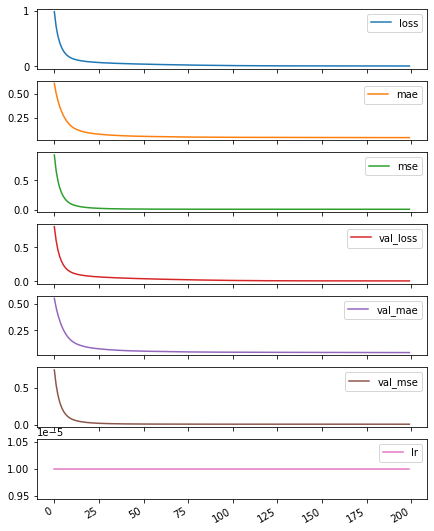

In [13]:
import pandas as pd
pd.DataFrame(history.history).plot(subplots=True, figsize=(7,10))

In [14]:
model.evaluate(X_test, y_test)

4583/4583 [==============================] - 3s 578us/step - loss: 0.0061 - mae: 0.0443 - mse: 0.0051


[0.0061442176811397076, 0.04433174058794975, 0.005140022840350866]

In [15]:
def symmetrize(x):
    i,j = np.triu_indices(3)
    M = np.empty((3,3), x.dtype)
    M[i,j] = x
    M[j,i] = x
    return M

In [16]:
y_test_hat = model.predict(X_test)
y_hat = model.predict(features)
b_test = np.array([symmetrize(y) for y in y_test])
b = np.array([symmetrize(l) for l in labels])
b_hat = np.array([symmetrize(y) for y in y_hat])
b_test_hat = np.array([symmetrize(y) for y in y_test_hat])

In [17]:
rand_ind = np.random.randint(0,len(X_test),5)
print('Picked 5 random indices from test set: ' + str(rand_ind))

for i in range(len(rand_ind)):
    print('Index: '+str(rand_ind[i]))
    print('Label anisotropy values: ')
    print(b_test[rand_ind[i],:].reshape((3,3)))
    print('Model prediction: ')
    print(symmetrize(model.predict(np.array([X_test[rand_ind[i],:]]))))

Picked 5 random indices from test set: [23084 97067 47931 72623 84327]
Index: 23084
Label anisotropy values: 
[[ 0.36408408 -0.08264552  0.        ]
 [-0.08264552 -0.3221859   0.        ]
 [ 0.          0.         -0.04189818]]
Model prediction: 
[[ 0.33101803 -0.03878967 -0.00096419]
 [-0.03878967 -0.27566943 -0.00123741]
 [-0.00096419 -0.00123741 -0.06065756]]
Index: 97067
Label anisotropy values: 
[[ 0.1218718  -0.11477379  0.        ]
 [-0.11477379 -0.09315612  0.        ]
 [ 0.          0.         -0.02871568]]
Model prediction: 
[[ 0.1979005  -0.07346693  0.00075383]
 [-0.07346693 -0.12100679 -0.00036375]
 [ 0.00075383 -0.00036375 -0.07568406]]
Index: 47931
Label anisotropy values: 
[[ 0.01700697 -0.01248382  0.        ]
 [-0.01248382 -0.00871787  0.        ]
 [ 0.          0.         -0.0082891 ]]
Model prediction: 
[[ 0.19884115 -0.06237539  0.00289088]
 [-0.06237539 -0.05421314  0.0002815 ]
 [ 0.00289088  0.0002815  -0.14167774]]
Index: 72623
Label anisotropy values: 
[[ 0.134

In [18]:
# fig = plt.figure(figsize=(30,15))

# for k, li in enumerate([b_test, b_test_hat, b_test_hat-b_test]):    
#     i = k*6 + 1
#     ax = fig.add_subplot(3,6,i,projection='3d')
#     ax.plot_trisurf(z, y, np.array([i[0][0] for i in li]), cmap='coolwarm')
#     ax = fig.add_subplot(3,6,i+1,projection='3d')
#     ax.plot_trisurf(z, y, np.array([i[0][1] for i in li]), cmap='coolwarm')
#     ax = fig.add_subplot(3,6,i+2,projection='3d')
#     ax.plot_trisurf(z, y, np.array([i[0][2] for i in li]), cmap='coolwarm')
#     ax = fig.add_subplot(3,6,i+3,projection='3d')
#     ax.plot_trisurf(z, y, np.array([i[1][1] for i in li]), cmap='coolwarm')
#     ax = fig.add_subplot(3,6,i+4,projection='3d')
#     ax.plot_trisurf(z, y, np.array([i[1][2] for i in li]), cmap='coolwarm')
#     ax = fig.add_subplot(3,6,i+5,projection='3d')
#     ax.plot_trisurf(z, y, np.array([i[2][2] for i in li]), cmap='coolwarm')